In [1]:
import kagglehub
import os
import matplotlib.pyplot as plt
import glob
import random
import cv2
import numpy as np

In [2]:
# Download latest version of data
top_level_path = kagglehub.dataset_download("pkdarabi/bone-fracture-detection-computer-vision-project", force_download=True)

# List top-level contents
print("Top level path:", top_level_path)
os.listdir(top_level_path)

# List data path contents
data_path = os.path.join(top_level_path, "BoneFractureYolo8")
print("Dataset path:", data_path)
os.listdir(data_path)

100%|█████████████████████████████████████████████████████████████████████████████| 84.1M/84.1M [00:02<00:00, 31.7MB/s]

Extracting files...


Top level path: C:\Users\zaras\.cache\kagglehub\datasets\pkdarabi\bone-fracture-detection-computer-vision-project\versions\2
Dataset path: C:\Users\zaras\.cache\kagglehub\datasets\pkdarabi\bone-fracture-detection-computer-vision-project\versions\2\BoneFractureYolo8


['data.yaml', 'README.dataset.txt', 'test', 'train', 'valid']

In [3]:
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")
valid_path = os.path.join(data_path, "valid")

In [4]:
os.listdir(train_path)

['images', 'labels']

In [5]:
train_label_path = os.path.join(train_path, "labels")
train_label_path

'C:\\Users\\zaras\\.cache\\kagglehub\\datasets\\pkdarabi\\bone-fracture-detection-computer-vision-project\\versions\\2\\BoneFractureYolo8\\train\\labels'

In [6]:
label_file_list = os.listdir(train_label_path)
label_file_list[0]

'distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1.txt'

In [7]:
fp = os.path.join(train_label_path, label_file_list[0])
fp

'C:\\Users\\zaras\\.cache\\kagglehub\\datasets\\pkdarabi\\bone-fracture-detection-computer-vision-project\\versions\\2\\BoneFractureYolo8\\train\\labels\\distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1.txt'

In [8]:
# NOTE: Purpose of this is to understand the label structure. Search up YOLOv8 label structure.

with open(fp, 'r') as file:
        content = file.read()
        print(content)

0 0.35585933923721313 0.3968750014901161 0.4525467435362568 0.3829741733292004 0.4556711770844495 0.47362547689055823 0.3681857266505504 0.48925501404327343


In [9]:
# Class IDs are the classes of each image, extracted from the first value in each text file
class_ids = []

for label_file in label_file_list:
    fp = os.path.join(train_label_path, label_file)
    
    with open(fp, "r") as f:
        for line in f:
            if line.strip():  # skip empty lines
                class_id = int(line.split()[0])
                class_ids.append(class_id)

print(class_ids[0:150])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 2, 2, 2, 2, 6, 6, 2, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 4, 4, 4, 0, 0, 0, 6, 6, 6, 6, 6, 6, 4, 3, 4, 3, 4, 3, 6, 6, 6, 1, 1, 1, 6, 6, 6, 6, 6, 6, 4, 4, 4, 0, 0, 0, 1, 1, 1, 2, 2, 2, 6, 6, 6, 1, 1, 1, 0, 0, 0, 4, 4, 6, 6, 6, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 0, 6, 6, 0, 0, 6, 0]


In [10]:
# Those class IDs can be mapped to the class names

class_names = [
    'elbow positive',
    'fingers positive',
    'forearm fracture',
    'humerus fracture',
    'humerus',
    'shoulder fracture',
    'wrist positive'
]

mapped_classes = [class_names[i] for i in class_ids]
print(mapped_classes[0:100])

['elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'shoulder fracture', 'shoulder fracture', 'shoulder fracture', 'wrist positive', 'wrist positive', 'wrist positive', 'wrist positive', 'wrist positive', 'wrist positive', 'humerus', 'humerus', 'humerus', 'humerus', 'humerus', 'humerus', 'shoulder fracture', 'shoulder fracture', 'shoulder fracture', 'wrist positive', 'forearm fracture', 'forearm fracture', 'forearm fracture', 'forearm fracture', 'wrist positive', 'wrist positive', 'forearm fracture', 'forearm fracture', 'fingers positive', 'fingers positive', 'fingers positive', 'elbow positive', 'elbow positive', 'elbow positive', 'forearm fracture', 'forearm fracture', 'forearm fracture', 'fingers positive', 'fingers positive', 'fingers positive', 'fingers positive', 'elbow positive', 'elbow positive', 'elbow positive', 'humerus', 'humerus', 'humerus', 'elbow positive', 'elb

In [11]:
def plot_split_hist(split_path: str, split_name: str, class_names: list[str]):
    label_dir = os.path.join(split_path, "labels")
    label_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]

    class_ids = []
    for lf in label_files:
        fp = os.path.join(label_dir, lf)
        with open(fp, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                class_ids.append(int(line.split()[0]))

    mapped = [class_names[i] for i in class_ids]
    counts = [mapped.count(cls) for cls in class_names]

    plt.figure(figsize=(8, 5))
    plt.bar(class_names, counts)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Class Distribution of {split_name} Data")
    plt.ylabel("Number of Annotations")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()


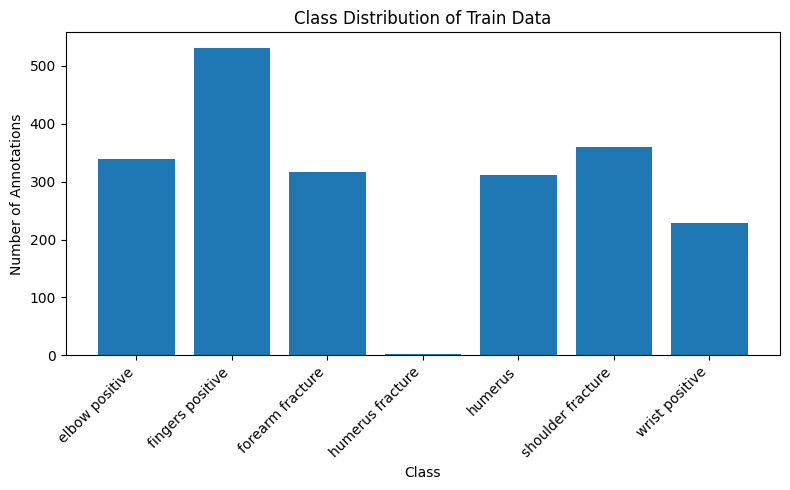

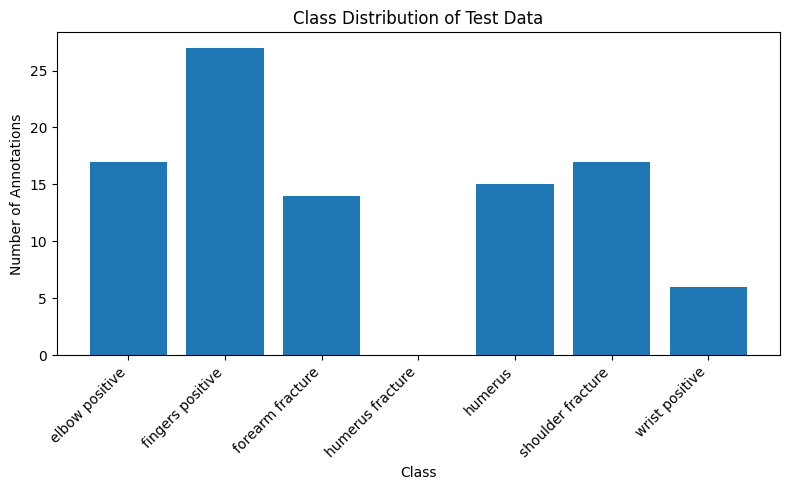

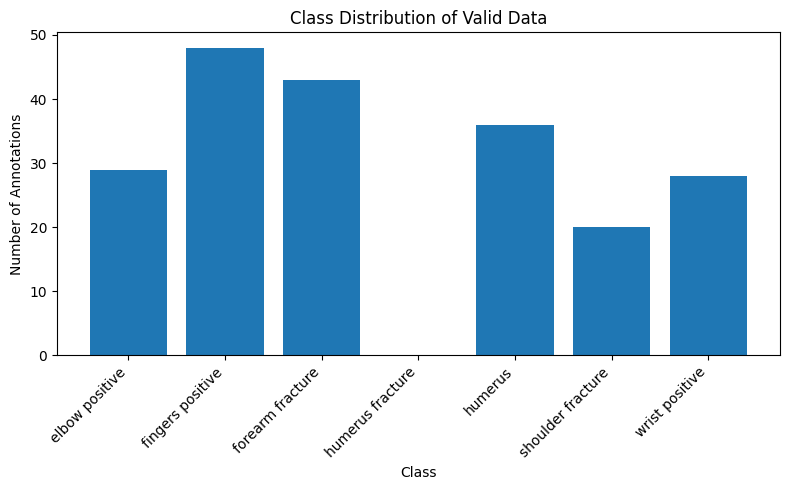

In [12]:
plot_split_hist(train_path, "Train", class_names)
plot_split_hist(test_path, "Test", class_names)
plot_split_hist(valid_path, "Valid", class_names)

# EDA Takeaways

- Humerus fracture and humerus are likely supposed to be the same category, there was just a mistake in annotation. Going to move "humerus" data points to "humerus fracture" and then remove the class "humerus"
- Should drop 100 datapoints at random from "fingers positive"
- Should generate 75 data points via augmentation for wrist positive.

In [13]:
# ChatGPT
def merge_humerus_to_fracture(split_dir, humerus_id=4, fracture_id=3):
    """
    Rewrites YOLO label files so that:
    class 'humerus' (id=4) becomes 'humerus fracture' (id=3)
    """

    labels_dir = os.path.join(split_dir, "labels")
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

    files_changed = 0

    for lf in label_files:
        with open(lf, "r") as f:
            lines = f.readlines()

        new_lines = []
        changed = False

        for line in lines:
            if line.strip():
                parts = line.strip().split()
                class_id = int(parts[0])

                if class_id == humerus_id:
                    parts[0] = str(fracture_id)
                    changed = True

                new_lines.append(" ".join(parts))
            else:
                new_lines.append(line.strip())

        if changed:
            files_changed += 1
            with open(lf, "w") as f:
                f.write("\n".join(new_lines) + "\n")

    print(f"Done. Updated {files_changed} label files in {split_dir}")

In [14]:
merge_humerus_to_fracture(train_path)
merge_humerus_to_fracture(test_path)
merge_humerus_to_fracture(valid_path)

Done. Updated 299 label files in C:\Users\zaras\.cache\kagglehub\datasets\pkdarabi\bone-fracture-detection-computer-vision-project\versions\2\BoneFractureYolo8\train
Done. Updated 14 label files in C:\Users\zaras\.cache\kagglehub\datasets\pkdarabi\bone-fracture-detection-computer-vision-project\versions\2\BoneFractureYolo8\test
Done. Updated 31 label files in C:\Users\zaras\.cache\kagglehub\datasets\pkdarabi\bone-fracture-detection-computer-vision-project\versions\2\BoneFractureYolo8\valid


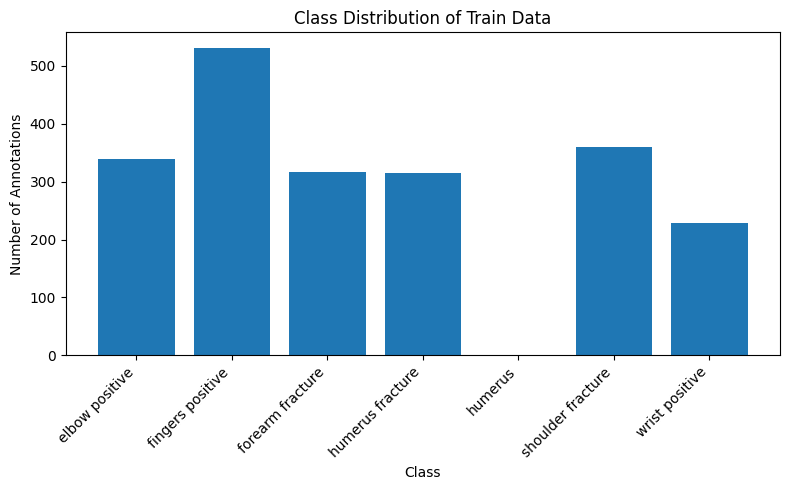

In [15]:
plot_split_hist(train_path, "Train", class_names)

In [16]:
class_names = [
    "elbow positive",
    "fingers positive",
    "forearm fracture",
    "humerus fracture",
    "shoulder fracture",
    "wrist positive"
]

In [17]:
# ChatGPT
def reindex_after_removing_humerus(split_dir):
    """
    After removing 'humerus' from class_names (old id 4),
    reindex the remaining classes in labels by shifting:
      5 -> 4   (shoulder fracture)
      6 -> 5   (wrist positive)
    """
    labels_dir = os.path.join(split_dir, "labels")
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

    files_changed = 0
    annots_changed = 0

    for lf in label_files:
        with open(lf, "r") as f:
            lines = f.readlines()

        new_lines = []
        changed_file = False

        for line in lines:
            if not line.strip():
                continue

            parts = line.strip().split()
            cid = int(parts[0])

            # remap only what you asked
            if cid == 5:
                parts[0] = "4"
                annots_changed += 1
                changed_file = True
            elif cid == 6:
                parts[0] = "5"
                annots_changed += 1
                changed_file = True

            new_lines.append(" ".join(parts))

        if changed_file:
            files_changed += 1
            with open(lf, "w") as f:
                f.write("\n".join(new_lines) + ("\n" if new_lines else ""))

    print(f"✅ {split_dir}")
    print(f"  Label files changed: {files_changed}")
    print(f"  Annotations relabeled: {annots_changed}")

In [18]:
reindex_after_removing_humerus(train_path)
reindex_after_removing_humerus(test_path)
reindex_after_removing_humerus(valid_path)

✅ C:\Users\zaras\.cache\kagglehub\datasets\pkdarabi\bone-fracture-detection-computer-vision-project\versions\2\BoneFractureYolo8\train
  Label files changed: 483
  Annotations relabeled: 588
✅ C:\Users\zaras\.cache\kagglehub\datasets\pkdarabi\bone-fracture-detection-computer-vision-project\versions\2\BoneFractureYolo8\test
  Label files changed: 21
  Annotations relabeled: 23
✅ C:\Users\zaras\.cache\kagglehub\datasets\pkdarabi\bone-fracture-detection-computer-vision-project\versions\2\BoneFractureYolo8\valid
  Label files changed: 36
  Annotations relabeled: 48


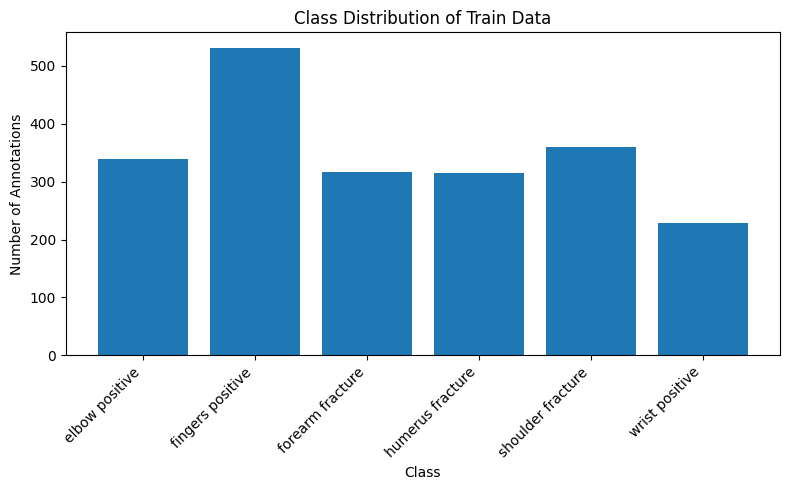

In [19]:
plot_split_hist(train_path, "Train", class_names)

In [20]:
# ChatGPT
def delete_fingers_positive(train_dir, class_id=1, n_delete=150, seed=42):
    random.seed(seed)

    images_dir = os.path.join(train_dir, "images")
    labels_dir = os.path.join(train_dir, "labels")

    candidate_labels = []

    # Find label files containing class_id
    for lf in glob.glob(os.path.join(labels_dir, "*.txt")):
        with open(lf, "r") as f:
            for line in f:
                if line.strip():
                    if int(line.split()[0]) == class_id:
                        candidate_labels.append(lf)
                        break

    print(f"Found {len(candidate_labels)} images containing class {class_id}")

    if len(candidate_labels) < n_delete:
        print("⚠ Not enough samples — deleting all available.")
        n_delete = len(candidate_labels)

    to_delete = random.sample(candidate_labels, n_delete)

    deleted = 0

    for lf in to_delete:
        stem = os.path.splitext(os.path.basename(lf))[0]

        # Delete label file
        os.remove(lf)

        # Delete corresponding image (try common extensions)
        for ext in ["jpg", "jpeg", "png", "webp", "bmp"]:
            img_path = os.path.join(images_dir, stem + "." + ext)
            if os.path.exists(img_path):
                os.remove(img_path)
                break

        deleted += 1

    print(f"✅ Permanently deleted {deleted} fingers-positive samples.")

In [21]:
delete_fingers_positive(train_path, class_id=1, n_delete=150)

Found 433 images containing class 1
✅ Permanently deleted 150 fingers-positive samples.


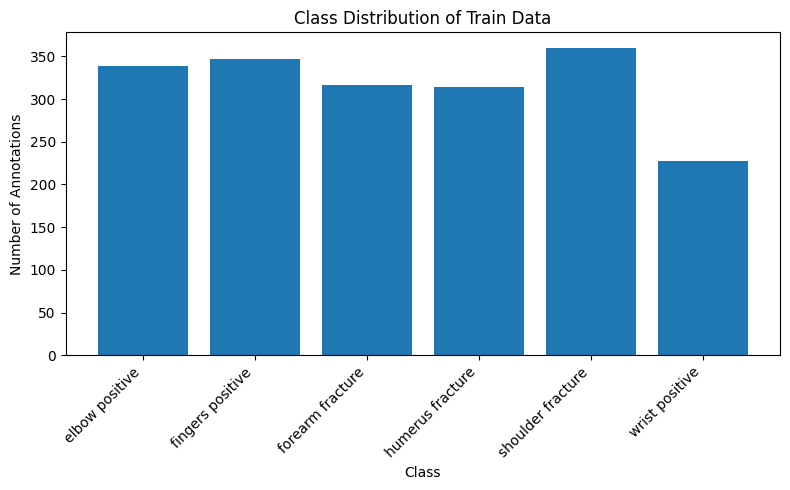

In [22]:
plot_split_hist(train_path, "Train", class_names)

In [23]:
def augment_wrist_positive(train_dir, class_id=5, n_new=75, seed=42):
    """
    Creates n_new augmented training samples for wrist positive (class_id=5).
    Saves new image+label files directly into train/images and train/labels.
    """

    random.seed(seed)

    images_dir = os.path.join(train_dir, "images")
    labels_dir = os.path.join(train_dir, "labels")

    # Find label files containing wrist positive
    candidate_labels = []

    for lf in glob.glob(os.path.join(labels_dir, "*.txt")):
        with open(lf, "r") as f:
            for line in f:
                if line.strip() and int(line.split()[0]) == class_id:
                    candidate_labels.append(lf)
                    break

    print(f"Found {len(candidate_labels)} wrist-positive samples.")

    if len(candidate_labels) == 0:
        print("❌ No wrist-positive samples found.")
        return

    created = 0

    for i in range(n_new):
        src_label = random.choice(candidate_labels)
        stem = os.path.splitext(os.path.basename(src_label))[0]

        # find image
        src_img = None
        for ext in ["jpg", "jpeg", "png", "webp", "bmp"]:
            p = os.path.join(images_dir, stem + "." + ext)
            if os.path.exists(p):
                src_img = p
                break

        if src_img is None:
            continue

        img = cv2.imread(src_img)
        if img is None:
            continue

        # read labels
        with open(src_label, "r") as f:
            labels = [ln.strip().split() for ln in f if ln.strip()]

        # Convert labels to float format
        labels = [[int(l[0]), float(l[1]), float(l[2]), float(l[3]), float(l[4])] for l in labels]

        # --- AUGMENTATIONS ---

        # Horizontal flip
        if random.random() < 0.5:
            img = cv2.flip(img, 1)
            for l in labels:
                l[1] = 1.0 - l[1]  # update x_center

        # Brightness / contrast
        alpha = random.uniform(0.9, 1.1)
        beta = random.uniform(-15, 15)
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

        # Small gaussian noise
        if random.random() < 0.3:
            noise = np.random.normal(0, 8, img.shape).astype(np.float32)
            img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

        # --- SAVE ---
        new_stem = f"{stem}_aug_{i:04d}"
        new_img_path = os.path.join(images_dir, new_stem + ".jpg")
        new_lbl_path = os.path.join(labels_dir, new_stem + ".txt")

        cv2.imwrite(new_img_path, img)

        with open(new_lbl_path, "w") as f:
            for l in labels:
                f.write(f"{l[0]} {l[1]:.6f} {l[2]:.6f} {l[3]:.6f} {l[4]:.6f}\n")

        created += 1

    print(f"✅ Created {created} augmented wrist-positive samples.")

In [24]:
augment_wrist_positive(train_path, class_id=5, n_new=75)

Found 168 wrist-positive samples.
✅ Created 75 augmented wrist-positive samples.


In [25]:
def show_augmented_pairs(train_dir, n_show=3):
    images_dir = os.path.join(train_dir, "images")

    # Find augmented images
    aug_images = sorted(glob.glob(os.path.join(images_dir, "*_aug_*.*")))

    if len(aug_images) == 0:
        print("No augmented images found.")
        return

    aug_images = aug_images[:n_show]

    fig, axes = plt.subplots(len(aug_images), 2, figsize=(12, 4*len(aug_images)))

    if len(aug_images) == 1:
        axes = [axes]

    for i, aug_path in enumerate(aug_images):
        aug_filename = os.path.basename(aug_path)

        # Extract original stem
        original_stem = aug_filename.split("_aug_")[0]

        # Find original image
        original_path = None
        for ext in ["jpg", "jpeg", "png", "webp", "bmp"]:
            candidate = os.path.join(images_dir, original_stem + "." + ext)
            if os.path.exists(candidate):
                original_path = candidate
                break

        if original_path is None:
            print(f"Original not found for {aug_filename}")
            continue

        # Load images
        orig = cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB)
        aug  = cv2.cvtColor(cv2.imread(aug_path), cv2.COLOR_BGR2RGB)

        axes[i][0].imshow(orig)
        axes[i][0].set_title("Original")
        axes[i][0].set_xlabel(original_path, fontsize=8)
        axes[i][0].axis("off")

        axes[i][1].imshow(aug)
        axes[i][1].set_title("Augmented")
        axes[i][1].set_xlabel(aug_path, fontsize=8)
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()

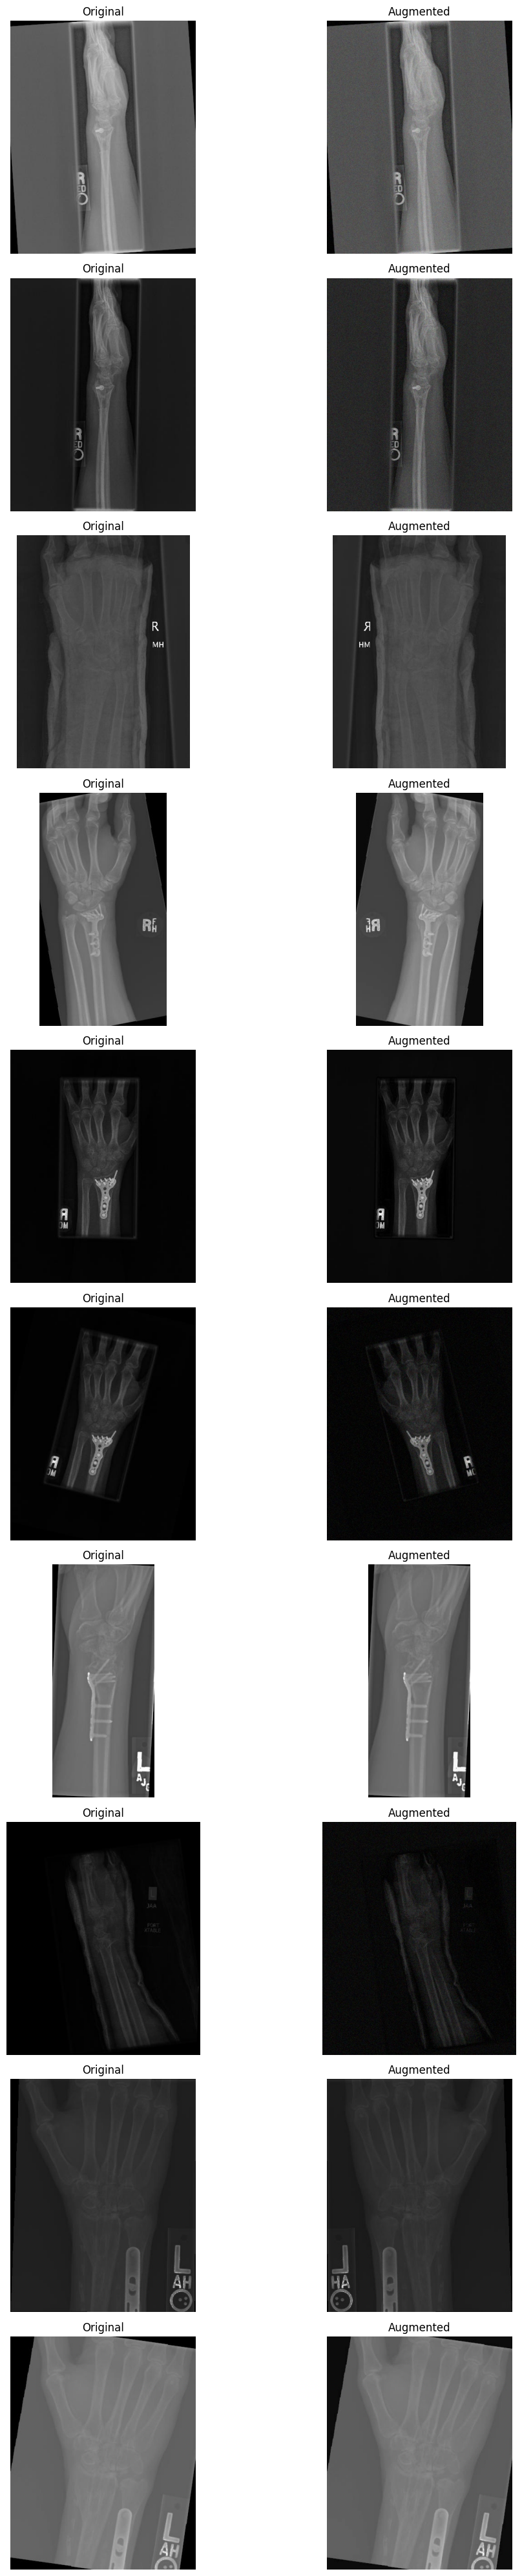

In [26]:
show_augmented_pairs(train_path, n_show=10)

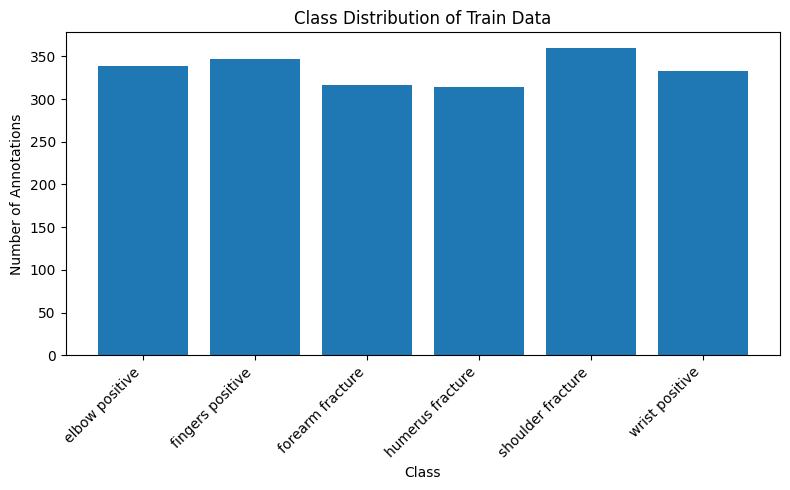

In [27]:
plot_split_hist(train_path, "Train", class_names)